In [1]:
import gymnasium as gym
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.algorithms.rl import RL
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# help funcs

def iter_count(V_track, theta): # computes iterations to convergence
    index = 0
    max_diff = theta+1
    while (max_diff > theta):
        if (index == (len(V_track)-1)):
            print("reached iter cap")
            return
        v1 = V_track[index]
        v2 = V_track[index+1]
        max_diff = max([np.abs(v1[i]-v2[i]) for i in range(len(v1))])
        index += 1
    print("converged in", index, "iterations")
    return index


def diff_arr(V_track):
    diffs = []
    for i in range(len(V_track)-1):
        v1 = V_track[i]
        v2 = V_track[i+1]
        diff = max(abs(v1-v2))
        
        if (not np.any(v2)): # all zeroes
            break
        else:
            diffs.append(diff)
    return diffs

def q_diff(Q_track):
    diffs = []
    for ep in range(len(Q_track)-1):
        v1 = np.matrix(Q_track[ep])
        v2 = np.matrix(Q_track[ep+1])
        diff = np.max(np.abs(v1-v2))
        diffs.append(diff)
    return diffs

def risk_factor(pi):
    return sum(pi.values())/(len(pi))

def hit_count(pi):
    return sum(pi.values())

def pi_diff(pi1, pi2):
    set1 = set(pi1.items())
    set2 = set(pi2.items())
    print(set1 ^ set2)
    

In [3]:
base_env = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env)

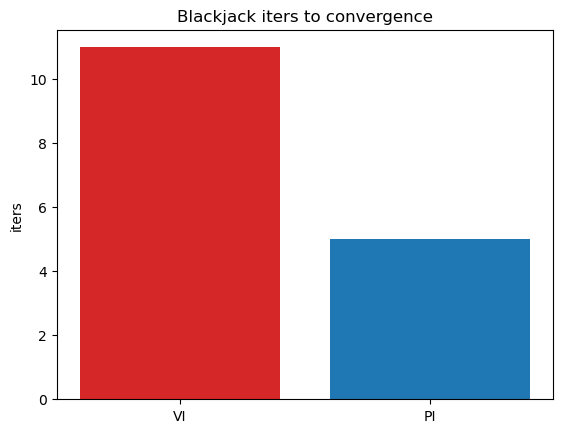

In [12]:
fig, ax = plt.subplots()

algs = ["VI", "PI"]
counts = [11,5]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(algs, counts, color=bar_colors)

ax.set_ylabel('iters')
ax.set_title('Blackjack iters to convergence')

plt.show()

In [5]:
## Value Iteration ##

V, V_track_vi, pi_vi = Planner(blackjack.P).value_iteration(n_iters=100, theta=1e-10, gamma=1.0)

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_vi, user_input=False)
print("VI mean scores:", np.mean(test_scores))
print("hit count:", hit_count(pi_vi))

runtime = 0.02 seconds


C:\Users\jmaal\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


VI mean scores: -0.035
hit count: 170


In [7]:
iter_count(V_track_vi, 10e-10)

converged in 11 iterations


11

In [10]:
## Policy Iteration ##
V, V_track_pi, pi_pi = Planner(blackjack.P).policy_iteration(n_iters=100, theta=1e-10)

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_pi, user_input=False)
print("PI mean scores:", np.mean(test_scores))
print("hit count:", hit_count(pi_pi))

runtime = 0.04 seconds
PI mean scores: -0.0465
hit count: 170


In [11]:
iter_count(V_track_pi, 10e-10)

converged in 5 iterations


5

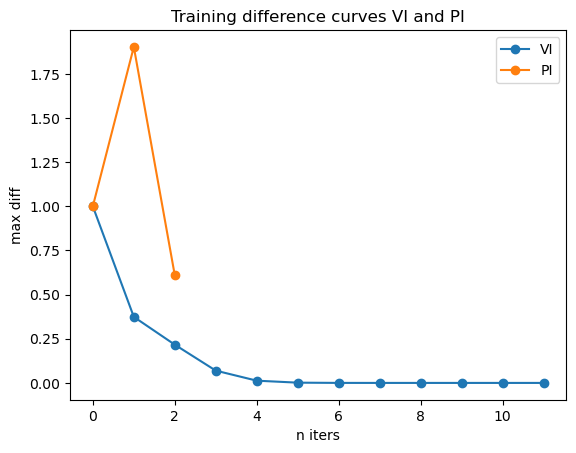

In [19]:
diffs_vi = diff_arr(V_track_vi)
diffs_pi = diff_arr(V_track_pi)

fig, ax = plt.subplots()
ax.set_title("Training difference curves VI and PI")
ax.set_ylabel("max diff")
ax.set_xlabel("n iters")
ax.plot(diffs_vi,marker="o")
ax.plot(diffs_pi,marker="o")
ax.legend(["VI", "PI"],loc="upper right")

In [13]:
## Q-learning ##
Q, V, pi_q, Q_track, pi_track = RL(blackjack).q_learning(
    gamma=.99, init_alpha=0.5, min_alpha=0.001, alpha_decay_ratio=0.9, 
    init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.99, n_episodes=100000)

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_q, user_input=False)
print("q learning mean scores:", np.mean(test_scores))
print("hit count:", hit_count(pi_q))

runtime = 9.90 seconds
q learning mean scores: -0.0345
hit count: 182


In [4]:
## Q-learning iters ##

iters = [10,100,1000,10000,100000]
hit_counts = []
scores = []

for n in iters:

    Q, V, pi_q, Q_track, pi_track = RL(blackjack).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.001, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=0.99, n_episodes=n)

    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_q, user_input=False)
    print("q learning mean scores:", np.mean(test_scores))
    scores.append(np.mean(test_scores))
    print("hit count:", hit_count(pi_q))
    hit_counts.append(hit_count(pi_q))

print("scores:", scores)
print("hit counts:", hit_counts)

  0%|                                                                                          | 0/10 [00:00<?, ?it/s]C:\Users\jmaal\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


runtime = 0.04 seconds
q learning mean scores: -0.2041
hit count: 4


runtime = 0.01 seconds


q learning mean scores: -0.1601
hit count: 30


runtime = 0.14 seconds


q learning mean scores: -0.1268
hit count: 117


runtime = 1.09 seconds
q learning mean scores: -0.0735
hit count: 164


runtime = 9.58 seconds
q learning mean scores: -0.0496
hit count: 185
scores: [-0.2041, -0.1601, -0.1268, -0.0735, -0.0496]
hit counts: [4, 30, 117, 164, 185]


[Text(0, 0, '10'),
 Text(1, 0, '100'),
 Text(2, 0, '1000'),
 Text(3, 0, '10000'),
 Text(4, 0, '100000')]

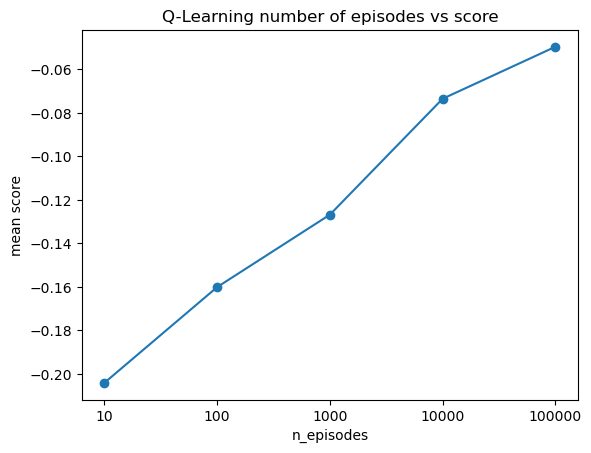

In [17]:
# plot scores
scores = [-0.2041, -0.1601, -0.1268, -0.0735, -0.0496]
x = [x for x in range(5)]
x_labels = ["10","100","1000","10000","100000"]
fig, ax = plt.subplots()

ax.set_title("Q-Learning number of episodes vs score")
ax.set_xlabel("n_episodes")
ax.set_ylabel("mean score")
ax.plot(scores, marker="o")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

[Text(0, 0, '10'),
 Text(1, 0, '100'),
 Text(2, 0, '1000'),
 Text(3, 0, '10000'),
 Text(4, 0, '100000')]

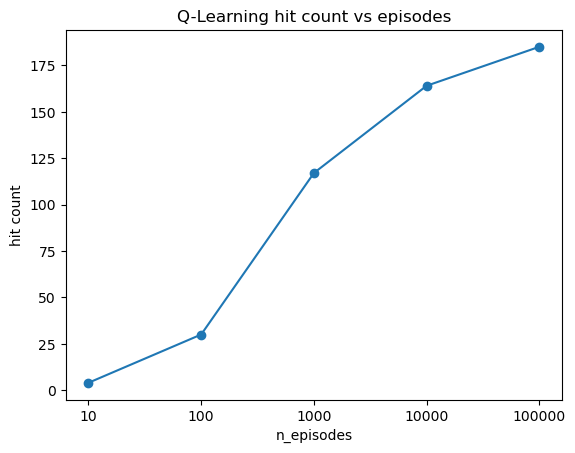

In [20]:
# plot hit count
hit_counts = [4, 30, 117, 164, 185]
x = [x for x in range(5)]
x_labels = ["10","100","1000","10000","100000"]
fig, ax = plt.subplots()

ax.set_title("Q-Learning hit count vs episodes")
ax.set_xlabel("n_episodes")
ax.set_ylabel("hit count")
ax.plot(hit_counts, marker="o")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

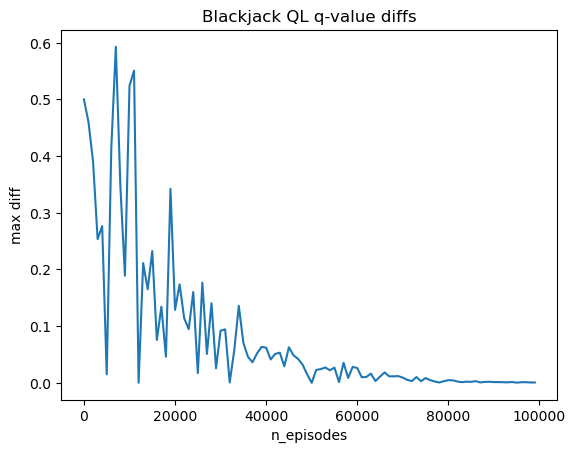

In [15]:
diffs = q_diff(Q_track)
diffs_p = [diffs[i] for i in range(0,len(diffs),1000)]
x = [x for x in range(0,len(diffs),1000)]

fig, ax = plt.subplots()
ax.set_title("Blackjack QL q-value diffs")
ax.set_ylabel("max diff")
ax.set_xlabel("n_episodes")
ax.plot(x,diffs_p)

In [8]:
# PI grid search
gamma = [0, .5, 1.0]
n_iters = [100,1000,10000]
theta = [1e-14,1e-10,1e-6]
GridSearch.pi_grid_search(blackjack, gamma, n_iters, theta)


running PI with gamma: 0  n_iters: 100  theta: 1e-14
runtime = 0.01 seconds
Avg. episode reward:  -0.22
###################
running PI with gamma: 0  n_iters: 100  theta: 1e-10
runtime = 0.01 seconds
Avg. episode reward:  -0.13
###################
running PI with gamma: 0  n_iters: 100  theta: 1e-06
runtime = 0.01 seconds
Avg. episode reward:  0.04
###################
running PI with gamma: 0  n_iters: 1000  theta: 1e-14
runtime = 0.01 seconds
Avg. episode reward:  0.15
###################
running PI with gamma: 0  n_iters: 1000  theta: 1e-10
runtime = 0.01 seconds
Avg. episode reward:  0.05
###################
running PI with gamma: 0  n_iters: 1000  theta: 1e-06
runtime = 0.01 seconds
Avg. episode reward:  -0.09
###################
running PI with gamma: 0  n_iters: 10000  theta: 1e-14
runtime = 0.01 seconds
Avg. episode reward:  0.04
###################
running PI with gamma: 0  n_iters: 10000  theta: 1e-10
runtime = 0.01 seconds
Avg. episode reward:  -0.11
###################
runni

In [54]:
## Value Iteration ##

V, V_track, pi = Planner(blackjack.P).value_iteration(n_iters=10, theta=1e-10)
print("risk 1:", risk_factor(pi))
set1 = set(pi.items())

Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning()
print("risk 2:", risk_factor(pi))
set2 = set(pi.items())

diff = set1 ^ set2

runtime = 0.05 seconds
risk 1: 170


runtime = 2.49 seconds
risk 2: 153


In [57]:
# Risk vs n-iters

n_iters = [10,100,1000,10000,100000]

for x in n_iters:
    Q, V, pi, Q_track, pi_track = RL(blackjack).q_learning(n_episodes=x)
    test_scores = TestEnv.test_env(env=blackjack, n_iters=1000, render=False, pi=pi, user_input=False)
    print("n_episodes:", x)
    print("q learning mean scores:", np.mean(test_scores))
    print("risk:",risk_factor(pi))

runtime = 0.01 seconds
n_episodes: 10
q learning mean scores: -0.127
risk: 0.03103448275862069


runtime = 0.03 seconds
n_episodes: 100
q learning mean scores: -0.241
risk: 0.10689655172413794


runtime = 0.09 seconds
n_episodes: 1000
q learning mean scores: -0.23
risk: 0.3896551724137931


runtime = 1.07 seconds
n_episodes: 10000
q learning mean scores: -0.1
risk: 0.5620689655172414


runtime = 11.18 seconds
n_episodes: 100000
q learning mean scores: -0.021
risk: 0.6068965517241379


In [100]:
# Risk vs n-iters


runtime = 0.01 seconds
risk: 6


runtime = 0.03 seconds
risk: 36


runtime = 0.25 seconds
risk: 123


runtime = 2.65 seconds
risk: 169


runtime = 28.47 seconds
risk: 177


In [105]:
Q, V, pi_q, Q_track, pi_track = RL(blackjack).q_learning(min_epsilon=0.01, n_episodes=100000)
V, V_track, pi_v = Planner(blackjack.P).value_iteration(n_iters=10000, theta=1e-10)

test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_q, user_input=False)
print("QL mean scores:", np.mean(test_scores))

test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_v, user_input=False)
print("VI mean scores:", np.mean(test_scores))

runtime = 29.58 seconds
runtime = 0.06 seconds
QL mean scores: -0.0439
VI mean scores: -0.0518


In [111]:
test_scores = TestEnv.test_env(env=blackjack, n_iters=200000, render=False, pi=pi_q, user_input=False)
print("QL mean scores:", np.mean(test_scores))

test_scores = TestEnv.test_env(env=blackjack, n_iters=200000, render=False, pi=pi_v, user_input=False)
print("VI mean scores:", np.mean(test_scores))

QL mean scores: -0.04642
VI mean scores: -0.04376


In [88]:
## Value Iteration ##

V, V_track, pi = Planner(blackjack.P).policy_iteration(n_iters=1000, theta=1e-2, gamma=1.0)
print("risk:", risk_factor(pi))

#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi, user_input=False)
print("VI mean scores:", np.mean(test_scores))

runtime = 0.06 seconds
risk: 170
VI mean scores: -0.0347


In [119]:
V, V_track, pi1 = Planner(blackjack.P).value_iteration(n_iters=1000, theta=1e-10, gamma=.2)
V, V_track, pi2 = Planner(blackjack.P).value_iteration(n_iters=1000, theta=1e-10, gamma=.99)

print("risk:", risk_factor(pi1),",", risk_factor(pi2))
pi_diff(pi1,pi2)

runtime = 0.05 seconds
runtime = 0.06 seconds
risk: 163 , 170
{(125, 0), (80, 1), (259, 0), (128, 0), (125, 1), (116, 0), (127, 0), (128, 1), (115, 0), (116, 1), (127, 1), (81, 0), (126, 0), (115, 1), (80, 0), (81, 1), (259, 1), (126, 1)}


In [121]:
Q, V, pi1, Q_track, pi_track = RL(blackjack).q_learning(
    gamma=.5,min_epsilon=0.01, epsilon_decay_ratio=0.99)
Q, V, pi2, Q_track, pi_track = RL(blackjack).q_learning(
    gamma=.99,min_epsilon=0.01, epsilon_decay_ratio=0.99)

print("risk:", risk_factor(pi1),",", risk_factor(pi2))
pi_diff(pi1,pi2)


#test policy
test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi1, user_input=False)
print("VI mean scores:", np.mean(test_scores))

test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi2, user_input=False)
print("VI mean scores:", np.mean(test_scores))

runtime = 2.54 seconds


runtime = 2.38 seconds
risk: 141 , 159
{(125, 0), (259, 0), (19, 0), (258, 1), (269, 1), (7, 1), (243, 0), (232, 0), (220, 1), (183, 0), (194, 0), (53, 0), (64, 0), (182, 1), (262, 0), (11, 0), (186, 1), (15, 0), (26, 0), (250, 1), (224, 0), (239, 0), (122, 0), (216, 1), (44, 1), (113, 0), (189, 1), (258, 0), (269, 0), (7, 0), (128, 0), (22, 0), (125, 1), (220, 0), (90, 0), (182, 0), (186, 0), (250, 0), (53, 1), (40, 1), (64, 1), (120, 0), (26, 1), (82, 0), (216, 0), (257, 1), (97, 0), (70, 1), (44, 0), (189, 0), (219, 1), (21, 1), (36, 1), (181, 1), (116, 0), (113, 1), (131, 0), (128, 1), (249, 1), (260, 1), (22, 1), (90, 1), (200, 1), (40, 0), (108, 0), (257, 0), (6, 0), (120, 1), (230, 1), (70, 0), (191, 0), (74, 0), (219, 0), (82, 1), (21, 0), (97, 1), (36, 0), (181, 0), (9, 1), (51, 0), (286, 1), (13, 1), (24, 1), (35, 1), (104, 0), (115, 0), (249, 0), (260, 0), (116, 1), (131, 1), (200, 0), (187, 0), (252, 1), (54, 1), (214, 1), (43, 0), (267, 1), (16, 1), (230, 0), (282, 1), (11

In [48]:
## Q-learning alpha  ##

alpha = [.1,.2,.5, .9]
hit_counts = []
scores = []

for a in alpha:

    Q, V, pi_q, Q_track, pi_track = RL(blackjack).q_learning(
        gamma=.99, init_alpha=a, min_alpha=0.001, alpha_decay_ratio=.9, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=.9, n_episodes=10000)

    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_q, user_input=False)
    print("q learning mean scores:", np.mean(test_scores))
    scores.append(np.mean(test_scores))
    print("hit count:", hit_count(pi_q))
    hit_counts.append(hit_count(pi_q))

print("***OUTPUT***")
print("scores:", scores)
print("hit counts:", hit_counts)

runtime = 0.99 seconds
q learning mean scores: -0.081
hit count: 152


runtime = 0.94 seconds
q learning mean scores: -0.085
hit count: 148


runtime = 1.08 seconds
q learning mean scores: -0.0803
hit count: 161


runtime = 0.93 seconds
q learning mean scores: -0.057
hit count: 169
***OUTPUT***
scores: [-0.081, -0.085, -0.0803, -0.057]
hit counts: [152, 148, 161, 169]


In [22]:
## Q-learning alpha decay ##

alpha_decay = [.1,.5,.9,.99]
hit_counts = []
scores = []

for d in alpha_decay:

    Q, V, pi_q, Q_track, pi_track = RL(blackjack).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.001, alpha_decay_ratio=d, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=.9, n_episodes=10000)

    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_q, user_input=False)
    print("q learning mean scores:", np.mean(test_scores))
    scores.append(np.mean(test_scores))
    print("hit count:", hit_count(pi_q))
    hit_counts.append(hit_count(pi_q))

print("***OUTPUT***")
print("scores:", scores)
print("hit counts:", hit_counts)

runtime = 0.94 seconds
q learning mean scores: -0.1175
hit count: 161


runtime = 1.00 seconds
q learning mean scores: -0.0926
hit count: 150


runtime = 0.97 seconds
q learning mean scores: -0.067
hit count: 163


runtime = 0.95 seconds
q learning mean scores: -0.0786
hit count: 162
***OUTPUT***
scores: [-0.1175, -0.0926, -0.067, -0.0786]
hit counts: [161, 150, 163, 162]


[Text(0, 0, '0.1'), Text(1, 0, '0.5'), Text(2, 0, '0.9'), Text(3, 0, '0.99')]

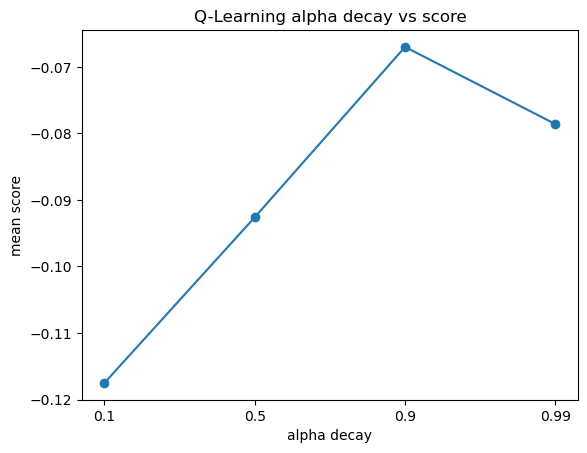

In [24]:
# alpha decay plot

scores = [-0.1175, -0.0926, -0.067, -0.0786]

x = [x for x in range(4)]
x_labels = [.1,.5,.9,.99]
fig, ax = plt.subplots()

ax.set_title("Q-Learning alpha decay vs score")
ax.set_xlabel("alpha decay")
ax.set_ylabel("mean score")
ax.plot(x,scores, marker="o")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

In [46]:
## Q-learning epsilon decay ##

epsilon_decay = [.1,.5,.9,.99]
hit_counts = []
scores = []

for d in epsilon_decay:

    Q, V, pi_q, Q_track, pi_track = RL(blackjack).q_learning(
        gamma=.99, init_alpha=0.5, min_alpha=0.001, alpha_decay_ratio=0.9, 
        init_epsilon=1.0, min_epsilon=0.01, epsilon_decay_ratio=d, n_episodes=10000)

    #test policy
    test_scores = TestEnv.test_env(env=blackjack, n_iters=10000, render=False, pi=pi_q, user_input=False)
    print("q learning mean scores:", np.mean(test_scores))
    scores.append(np.mean(test_scores))
    print("hit count:", hit_count(pi_q))
    hit_counts.append(hit_count(pi_q))

print("***OUTPUT***")
print("scores:", scores)
print("hit counts:", hit_counts)

runtime = 1.04 seconds
q learning mean scores: -0.0996
hit count: 173


runtime = 0.99 seconds
q learning mean scores: -0.0729
hit count: 165


runtime = 0.99 seconds
q learning mean scores: -0.0874
hit count: 160


runtime = 0.93 seconds
q learning mean scores: -0.0783
hit count: 157
***OUTPUT***
scores: [-0.0996, -0.0729, -0.0874, -0.0783]
hit counts: [173, 165, 160, 157]


[Text(0, 0, '0.1'), Text(1, 0, '0.5'), Text(2, 0, '0.9'), Text(3, 0, '0.99')]

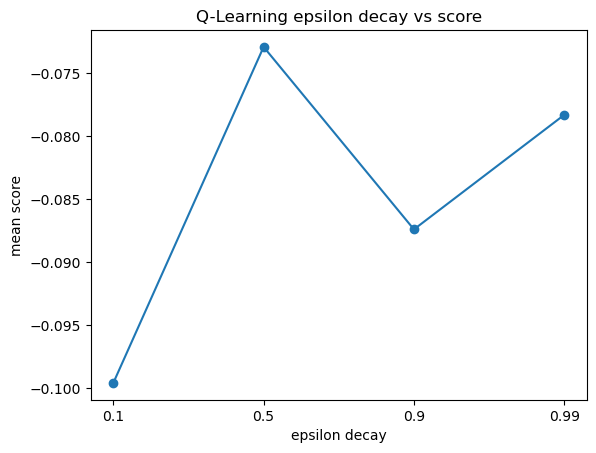

In [21]:
# eps decay plot

scores =[-0.0996, -0.0729, -0.0874, -0.0783]

x = [x for x in range(4)]
x_labels = [.1,.5,.9,.99]
fig, ax = plt.subplots()

ax.set_title("Q-Learning epsilon decay vs score")
ax.set_xlabel("epsilon decay")
ax.set_ylabel("mean score")
ax.plot(x,scores, marker="o")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

Text(0, 0.5, 'score')

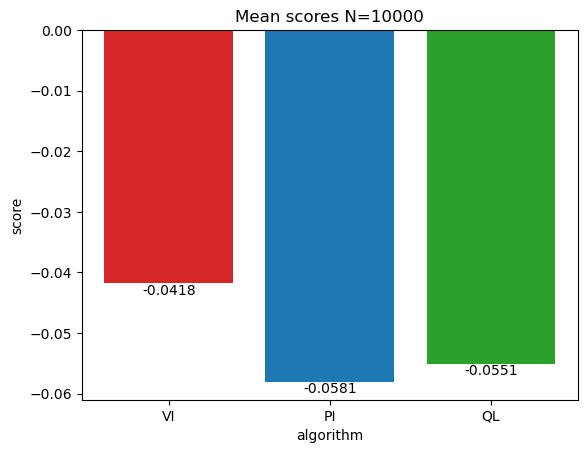

In [20]:
# Plot scores

scores = [-0.0418, -0.0581, -0.0551]
algs = ["VI", "PI", "QL"]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']
fig, ax = plt.subplots()
ax.bar(algs, scores,color=bar_colors)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_title("Mean scores N=10000")
ax.set_xlabel("algorithm")
ax.set_ylabel("score")

Text(0, 0.5, 'time (seconds)')

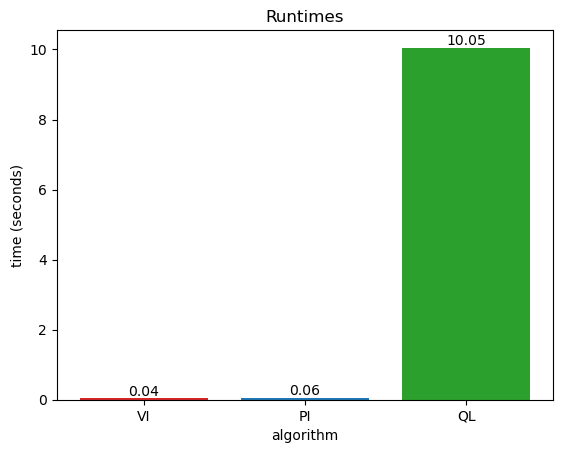

In [21]:
# Plot training time

times = [.04,.06, 10.05]
algs = ["VI", "PI", "QL"]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']
fig, ax = plt.subplots()
ax.bar(algs, times,color=bar_colors)
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_title("Runtimes")
ax.set_xlabel("algorithm")
ax.set_ylabel("time (seconds)")